jupyter-lab --allow-root --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

Test R-CNN Code (Tensorflow)

1. Create training data
Generate Region Proposals
are generated using the selective search algorithm. Selective search is an algorithm that groups similar elements based texture, color, shape or size. It is hierachical, so it starts to define very fine-grained elements and combines them to bigger elements. Ultimately it will yield multiple region proposals. It is noteworthy that this algorithm has nothing to do with machine learning, later methods replace that element with neural networks.

Check region proposals
Since we have the real object detection rectangles for an image, we can compare the region proposal to the ground truths. We use a method called intersection over union (IoU). It measures the overlap between the predicted proposal and ground truth. If it is bigger than 50%, we classify the prediction as a positiv sample. In this way we build our positive and negative training classes.

Extract images
In this implementation we crop the images (using the region proposals) and save them as images in a folder.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import pathlib
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import requests
import cv2
from PIL import Image

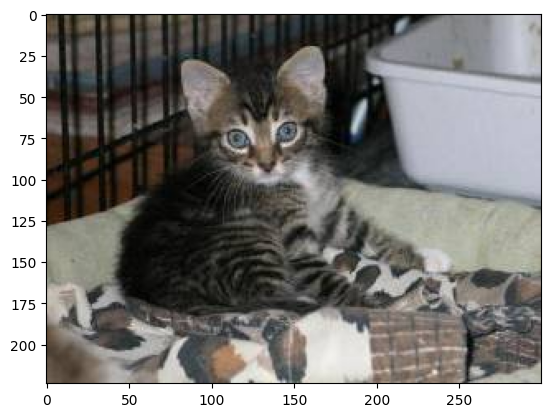

In [2]:
im = plt.imread("/Users/crossrunway/DataSets/catVSdog/cat.12.jpg")
plt.imshow(im)
plt.show()

In [3]:
def extract_ground_truth(path):
    """Extracts ground truths like boxes, labels and ids from xml files."""

    boxes = []
    labels = []
    ids = []

    tree = ET.parse(path)
    id_i = path.split("/")[-1].split(".")[1]
    objects = tree.getroot().findall("object")

    for object_i in objects:
        object_name = object_i.find("name").text
        if object_name=="cat":
            instances = object_i.findall("bndbox")
            for instance in instances:
                xmin = int(float(instance.find("xmin").text))
                xmax = int(float(instance.find("xmax").text))
                ymin = int(float(instance.find("ymin").text))
                ymax = int(float(instance.find("ymax").text))
                box = np.array([xmin, xmax, ymin, ymax])
                boxes.append(box)
                labels.append(object_name)
                ids.append(id_i)
        return np.array(boxes), np.array(labels), np.array(ids) #We will only consider last item, can be changed in future iterations

In [4]:
def region_proposals(image):
    """Generates region proposals using Selective Search"""
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()

    prediction_rects = _restructure_rectangles_xx(rects)
    return prediction_rects

def _restructure_rectangles_xx(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, x2, y1, y2)"""
    x1 = old_rects[:,0]
    x2 = old_rects[:,2]+old_rects[:,0]
    y1 = old_rects[:,1]
    y2 = old_rects[:,1]+old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,0] = x1
    rects_new[:,1] = x2
    rects_new[:,2] = y1
    rects_new[:,3] = y2
    return rects_new

In [5]:
def images_to_file(image, boxes, labels, predicted_rectangles, image_id, path="."):
    """Crops boxes and writes images to files."""

    if not os.path.exists(f"{path}/{labels[0]}"):
        os.makedirs(f"{path}/{labels[0]}")
    if not os.path.exists(f"{path}/no_category"):
        os.makedirs(f"{path}/no_category")

    # Iterate through boxes
    for box, label, i_id in zip(boxes, labels, image_id):
        i_pos = i_neg = 0
        for rect in predicted_rectangles:
            iou = _get_iou(box,rect)
            if iou > 0.5:
                i_pos +=1
                file_name = f"{path}/{label}/{i_id}_{i_pos}.jpg"
                cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                img = Image.fromarray(cropped_image, 'RGB')
                img2 = img.resize((227,227), Image.ANTIALIAS)
                img2.save(file_name)
            elif iou < 0.1 and i_neg < 50:
                if (rect[3]-rect[2])>20 and (rect[1]-rect[0])>20:
                    i_neg += 1
                    file_name = f"{path}/no_category/{label}_{i_id}_{i_neg}.jpg"
                    cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                    img = Image.fromarray(cropped_image, 'RGB')
                    img2 = img.resize((227,227), Image.ANTIALIAS)
                    img2.save(file_name)


In [6]:
# Inspired by https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def _get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : array
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : array
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[1]
    assert bb1[2] < bb1[3]
    assert bb2[0] < bb2[1]
    assert bb2[2] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[2], bb2[2])
    x_right = min(bb1[1], bb2[1])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[1] - bb1[0]) * (bb1[3] - bb1[2])
    bb2_area = (bb2[1] - bb2[0]) * (bb2[3] - bb2[2])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
metadata_paths = sorted(glob("/Users/crossrunway/DataSets/catVSdog/cat*.xml"))
images_paths = sorted(glob("/Users/crossrunway/DataSets/catVSdog/cat*.jpg"))

In [8]:
for metadata_path, image_path in tqdm(zip(metadata_paths, images_paths)):
    if os.stat(image_path).st_size < 100000:
        image = cv2.imread(image_path)

        truth_recangles, truth_label, image_id = extract_ground_truth(metadata_path)

        if truth_label:
            predicted_rectangles = region_proposals(image)
            images_to_file(image, truth_recangles, truth_label, predicted_rectangles, image_id, "./training")

0it [00:00, ?it/s]/var/folders/zh/f13wlt3119n42mtygntvxztw0000gn/T/ipykernel_3044/1397872332.py:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)
/var/folders/zh/f13wlt3119n42mtygntvxztw0000gn/T/ipykernel_3044/1397872332.py:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)
136it [01:44,  1.89it/s]/var/folders/zh/f13wlt3119n42mtygntvxztw0000gn/T/ipykernel_3044/1887002174.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if truth_label:
550it [06:58,  1.32it/s]


2. Train Neural Network
In the original paper the authors use a neural network to output a 4096-dimensional representation of an image. This implementations classifies the output (region proposals of cat vs. no cat) directly. It uses transfer learning by re-training a MobileNetV2. Futhermore various steps to augment the image data by shifting, rotating or flipping pixels are used.

I simplified the training (no verification data, no hyperparameter search) to save some of my time ;)

In [9]:
data_train = keras.utils.image_dataset_from_directory("./training", image_size=(227,227))

Found 42074 files belonging to 2 classes.
Metal device set to: Apple M1


2023-07-09 13:48:38.452581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-09 13:48:38.453165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
data_train.class_names

['cat', 'no_category']

In [11]:
# Inspired by https://pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/
# Create neural network
class_weight = {0: 5, 1: 1}

input_l = keras.layers.Input(shape=(227, 227, 3))
input_layer = keras.layers.Rescaling(1./255)(input_l)
input_layer = keras.layers.ZeroPadding2D((16,16))(input_layer)
input_layer = keras.layers.RandomCrop(227,227)(input_layer)
input_layer = keras.layers.RandomFlip("horizontal")(input_layer)

headModel = keras.applications.MobileNetV2(weights="imagenet", include_top=False,input_tensor=input_layer)

for layer in headModel.layers:
    layer.trainable = False

headModel = headModel.output

baseModel = keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
baseModel = keras.layers.Flatten(name="flatten")(baseModel)
baseModel = keras.layers.Dense(128, activation="relu")(baseModel)
baseModel = keras.layers.Dropout(0.3)(baseModel)
output = keras.layers.Dense(2, activation="softmax")(baseModel)


model = keras.models.Model(inputs=input_l, outputs=output)

9406464/9406464 [==============================] - 1s 0us/step


In [12]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

history = model.fit(data_train, epochs=10, batch_size=64, class_weight=class_weight)

Epoch 1/10


2023-07-09 13:48:51.020685: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2023-07-09 13:48:52.233392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-09 13:48:52.312816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model/random_crop/loop_body/cond/pfor/cond/branch_executed/_192


1315/1315 [==============================] - 451s 340ms/step - loss: 0.0980 - accuracy: 0.9808
Epoch 2/10
1315/1315 [==============================] - 450s 342ms/step - loss: 0.0603 - accuracy: 0.9874
Epoch 3/10
1315/1315 [==============================] - 443s 337ms/step - loss: 0.0508 - accuracy: 0.9892
Epoch 4/10
1315/1315 [==============================] - 445s 338ms/step - loss: 0.0459 - accuracy: 0.9902
Epoch 5/10
1315/1315 [==============================] - 447s 340ms/step - loss: 0.0392 - accuracy: 0.9914
Epoch 6/10
1315/1315 [==============================] - 451s 343ms/step - loss: 0.0348 - accuracy: 0.9925
Epoch 7/10
1315/1315 [==============================] - 457s 348ms/step - loss: 0.0305 - accuracy: 0.9931
Epoch 8/10
1315/1315 [==============================] - 464s 353ms/step - loss: 0.0305 - accuracy: 0.9937
Epoch 9/10
1315/1315 [==============================] - 462s 351ms/step - loss: 0.0247 - accuracy: 0.9942
Epoch 10/10
1315/1315 [==============================] - 

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 227, 227, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 259, 259, 3)  0          ['rescaling[0][0]']              
                                                                                                  
 random_crop (RandomCrop)       (None, 227, 227, 3)  0           ['zero_padding2d[0][0]']     

3. Prediction
Download prediction data
For demonstration purpose I use an example image from Google Images search to verify the algorithm.

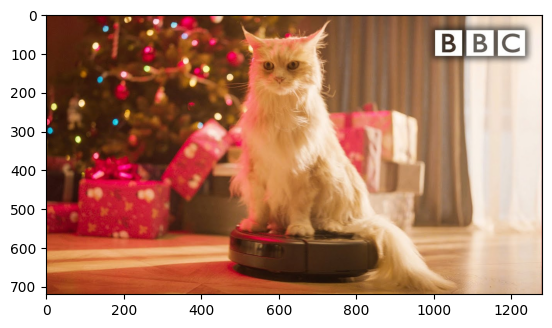

In [14]:
prediction_sample = "https://i.ytimg.com/vi/K1Xkt1E7PJY/maxresdefault.jpg"

response = requests.get(prediction_sample)

with open("./prediction.jpg", 'wb') as f:
    f.write(response.content)

prediction = plt.imread("./prediction.jpg")

plt.imshow(prediction)
plt.show()

In [15]:
def images_to_file_prediction(image, predicted_rectangles, path="."):
    """Crops boxes and writes images to files."""

    if not os.path.exists(f"{path}/"):
        os.makedirs(f"{path}/")

    i_id = 0

    for predicted_rectangle in predicted_rectangles:
        file_name = f"{path}/{i_id}.jpg"
        cropped_image = image[predicted_rectangle[2]:predicted_rectangle[3], predicted_rectangle[0]:predicted_rectangle[1]]
        img = Image.fromarray(cropped_image, 'RGB')
        img2 = img.resize((227,227), Image.ANTIALIAS)
        img2.save(file_name)
        i_id +=1

In [16]:
predicton_rectangles = region_proposals(prediction)
images_to_file_prediction(prediction, predicton_rectangles, path="./prediction/pred")

/var/folders/zh/f13wlt3119n42mtygntvxztw0000gn/T/ipykernel_3044/1611274497.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)


Generate predictions¶

In [17]:
# When doing prediction ALWAYS set the shuffle parameter to False. Otherwise you can't trace the order of files correctly.
prediction_data = keras.utils.image_dataset_from_directory("./prediction", image_size=(227,227), shuffle=False)

# Model prediction
prediction_output = model.predict(prediction_data, batch_size=1)

Found 3291 files belonging to 1 classes.


2023-07-09 15:37:06.760725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 17s 160ms/step


In [18]:
def _restructure_rectangles_xy(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, y1, x2, y2)"""
    x1 = old_rects[:,0]
    x2 = old_rects[:,1]
    y1 = old_rects[:,2]
    y2 = old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,1] = x1
    rects_new[:,0] = y1
    rects_new[:,3] = x2
    rects_new[:,2] = y2
    return rects_new

new_pred_rects = _restructure_rectangles_xy(predicton_rectangles)

In [19]:
# Method that "prunes away boxes that have high intersection-over-union (IOU) overlap with previously selected boxes" (Tensorflow Docs)
predictions = tf.image.non_max_suppression(new_pred_rects, prediction_output[:,0], max_output_size=3, iou_threshold=0.5)

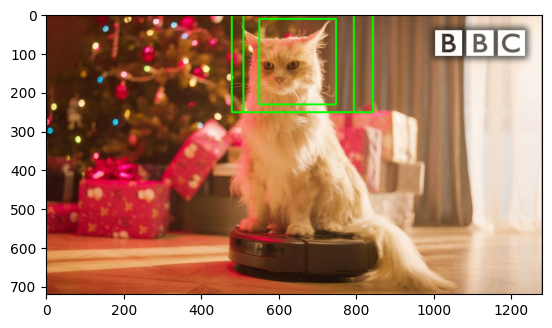

In [20]:
image = plt.imread("./prediction.jpg")

for ind_rect in predictions.numpy():
    img_index = int(prediction_data.file_paths[ind_rect].split("/")[-1].split(".")[0])
    rectangle_coordinates = predicton_rectangles[img_index].astype(int)
    rectangled_image = cv2.rectangle(image, (rectangle_coordinates[0], rectangle_coordinates[2]), (rectangle_coordinates[1], rectangle_coordinates[3]), (0, 255, 0), 3)
    plt.imshow(rectangled_image)

plt.show()